<a id="1"></a>
# <p style="background-color:#02991d;font-family:georgia,serif;color:#FFF8ED;font-size:150%;text-align:center;border-radius:10px 10px;">Podcast Listening Time</p>
___

<div style="text-align: center;">
  <img src="https://i.pinimg.com/736x/cf/04/4d/cf044d9aad3e8095f43ccae9369398dc.jpg" alt="Podcast image" width="500">
</div>

___

## About:
In this notebook i will perform some EDA to understand the features more, then play with different techniques to improve the CV score!

*Notes:* 
i added some features that i noticed improvements from.

<a id="1"></a>
# <p style="background-color:#02991d;font-family:georgia,serif;color:#FFF8ED;font-size:120%;text-align:center;border-radius:10px 10px;">Imports and Cleaning</p>

In [1]:
import numpy as np
import math
import pandas as pd 
import matplotlib.pyplot as plt
palette_1 = ["forestgreen", "limegreen", "darkgreen", "green", "lime"]
palette_2 = ["seagreen", "mediumseagreen", "springgreen", "mintcream", "mediumspringgreen"]
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from tqdm.auto import tqdm
import optuna
import warnings
warnings.filterwarnings("ignore")

In [2]:
submission = pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [3]:
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [4]:
print(train.info(), "\n", test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [5]:
def nans_summary(df):
    missing_df = df.isnull().sum()
    missing_df = missing_df[missing_df > 0].reset_index()
    missing_df.columns = ['Column', 'Missing Values']
    return missing_df.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)

nans_summary(train)

,Column,Missing Values
0,Guest_Popularity_percentage,146030
1,Episode_Length_minutes,87093
2,Number_of_Ads,1


In [6]:
nans_summary(test)

,Column,Missing Values
0,Guest_Popularity_percentage,48832
1,Episode_Length_minutes,28736


In [7]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


### <span style="color: #048f29;">Univariate Analysis:</span>

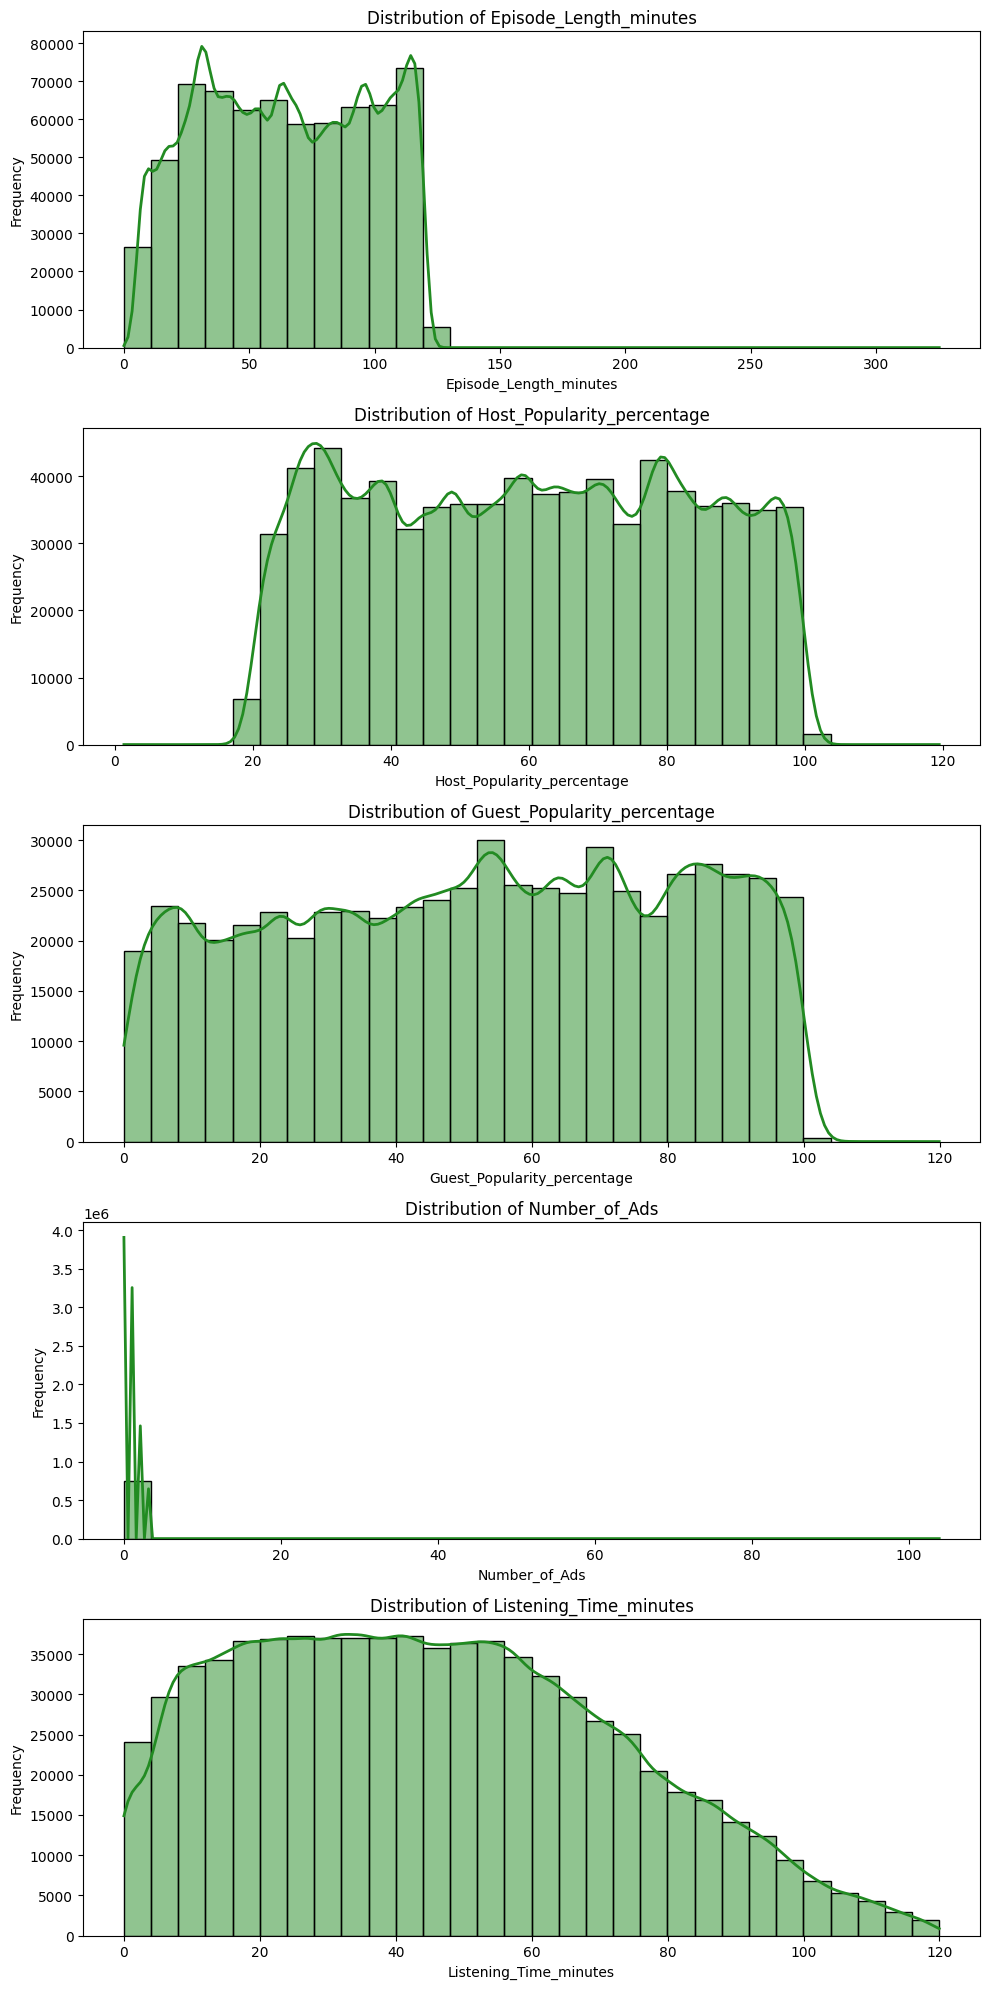

In [8]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

num_cols = [col for col in num_cols if col != 'id']

n = len(num_cols)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n))
if n == 1: 
    axes = [axes]

for ax, col in zip(axes, num_cols):
    sns.histplot(train[col], kde=True, ax=ax, bins=30,  color="forestgreen", line_kws={'color': "limegreen", 'linewidth': 2})
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

---
##### <span style="color: #048f29;">Notes: </span>
*Apparently there are a few outliers that are messing with the ditributions, especially in Number_of_Ads and Episode_Length_minutes*

---

In [9]:
print("Skewness:", train['Listening_Time_minutes'].skew())

Skewness: 0.3508122585099899


In [10]:
# num of ads outliers
NoA_outliers = train[(train["Number_of_Ads"] > 3)].shape[0]
NoA_outliers_test = test[(test["Number_of_Ads"] > 3)].shape[0]
print(f"Number of Ads Outliers in Training: {NoA_outliers}", "\n", f"Number of Ads Ouliers in Testing: {NoA_outliers_test}")

Number of Ads Outliers in Training: 9 
 Number of Ads Ouliers in Testing: 2


In [11]:
# episode length outliers
ELm_outliers = train[(train["Episode_Length_minutes"] > 150)].shape[0]
ELm_outliers_test = test[(test["Episode_Length_minutes"] > 150)].shape[0]
print(f"Eps Length minutes Outliers in Training: {NoA_outliers}", "\n", f"Eps Length minutes Ouliers in Testing: {NoA_outliers_test}")

Eps Length minutes Outliers in Training: 9 
 Eps Length minutes Ouliers in Testing: 2


*This is Interesting, it seems that they are the same podcasts!*

So my approach will be to drop those values from the training set now even before processing, so i can visualize the data better!

---

### <span style="color: #048f29;">Categorical Analysis:</span>

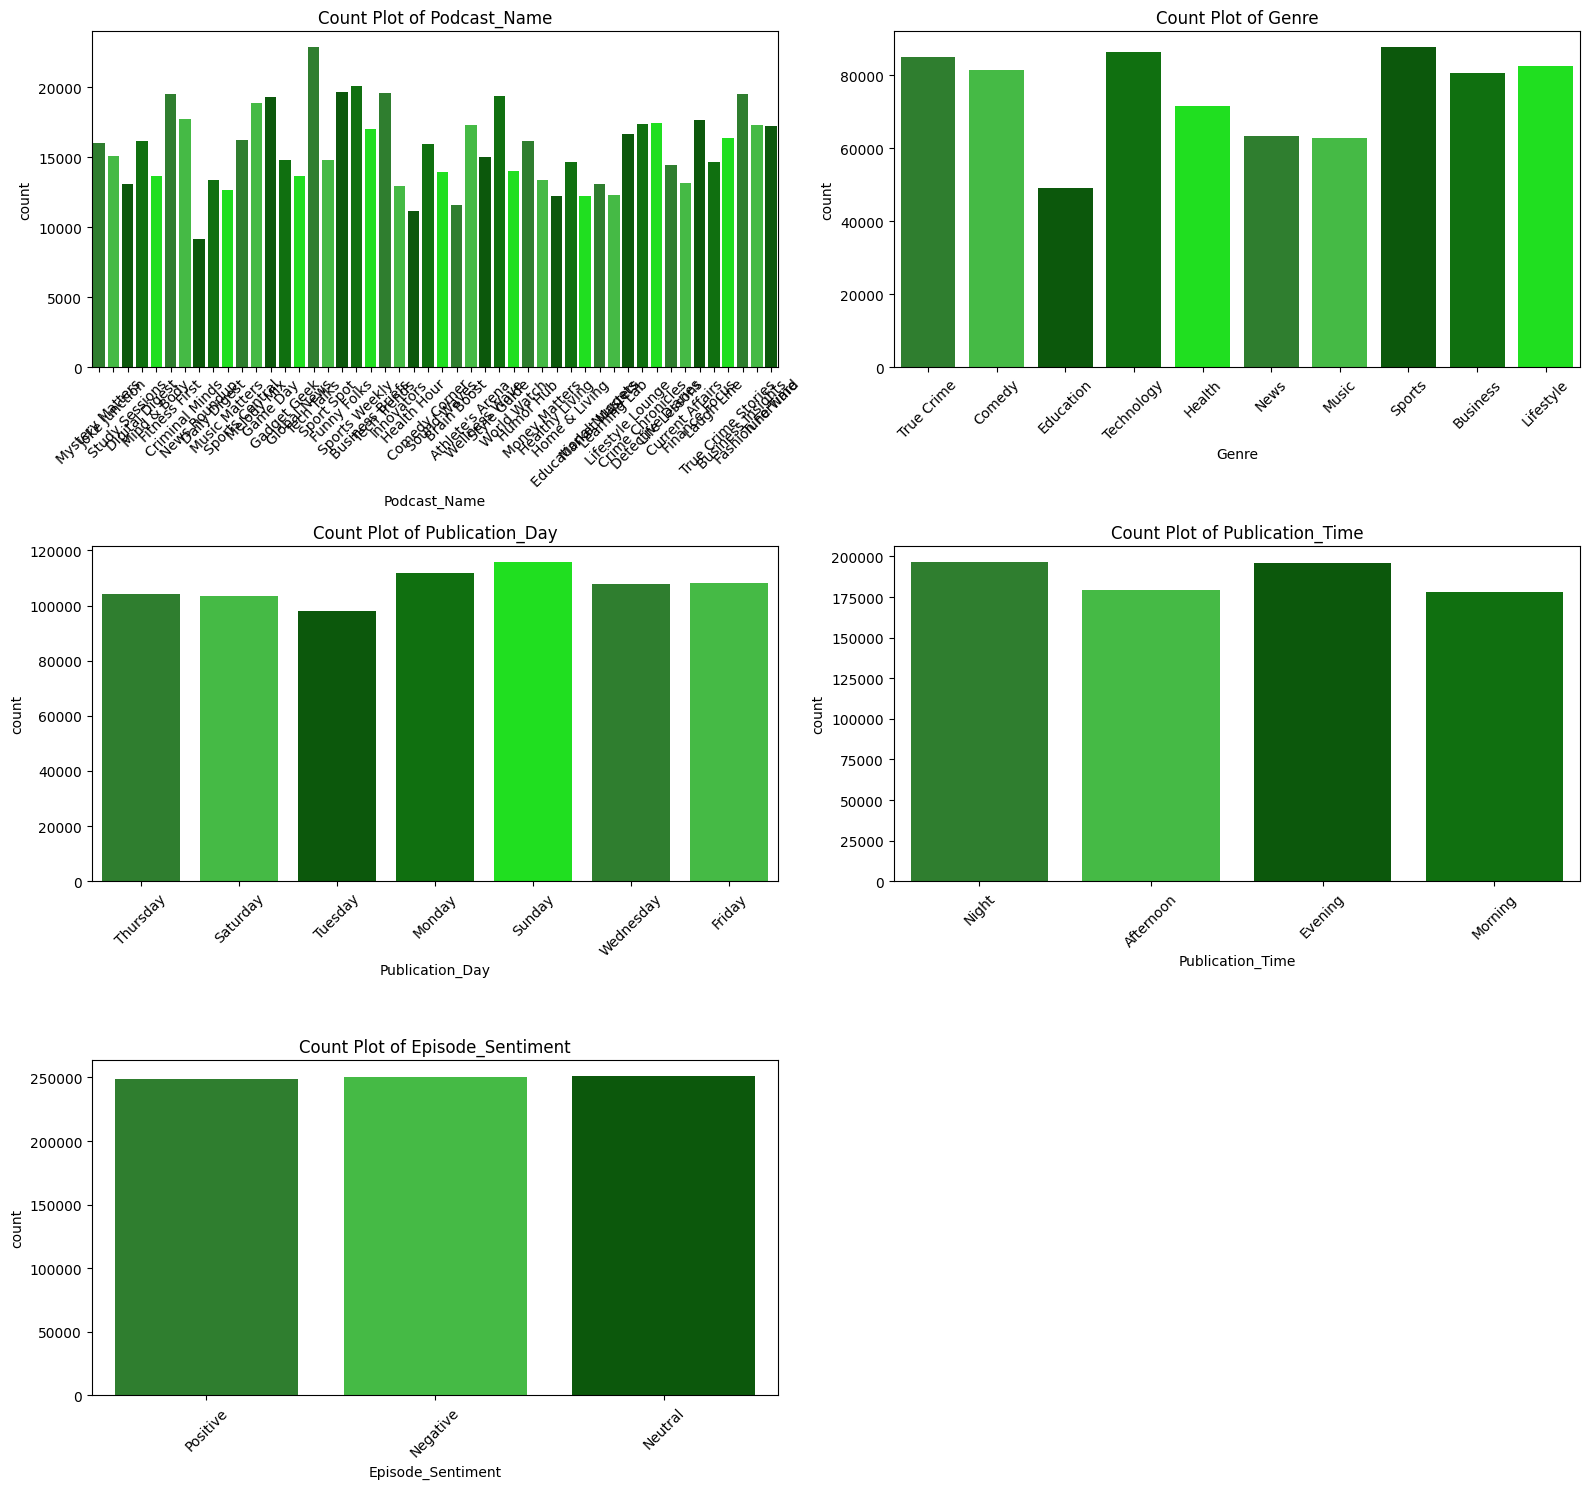

In [12]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if train[col].nunique() < 50]

ncols = 2
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Loop through each categorical column
for i, col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, ax=axes[i], palette=palette_1)
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots (if total plots is not even)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
# deleting the few outliers for better analysis
rows_to_drop = []
for index, row in train.iterrows():
    if row['Number_of_Ads'] > 3 or row['Episode_Length_minutes'] > 150:
        rows_to_drop.append(index)

# Drop the identified rows from the DataFrame
train.drop(rows_to_drop, inplace=True)

num_cols = train.select_dtypes(include=['int64', 'float64']).columns

num_cols = [col for col in num_cols if col != 'id']

train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,749990.000000,662897.000000,749990.000000,603962.000000,749989.000000,749990.000000
mean,374998.377742,64.503982,59.860114,52.236653,1.347886,45.436956
std,216506.624482,32.967925,22.873121,28.451225,1.110967,27.137945
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187498.250000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374997.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562497.750000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,120.930000,119.460000,119.910000,3.000000,119.970000


### <span style="color: #048f29;">Bivariate Analysis:</span>

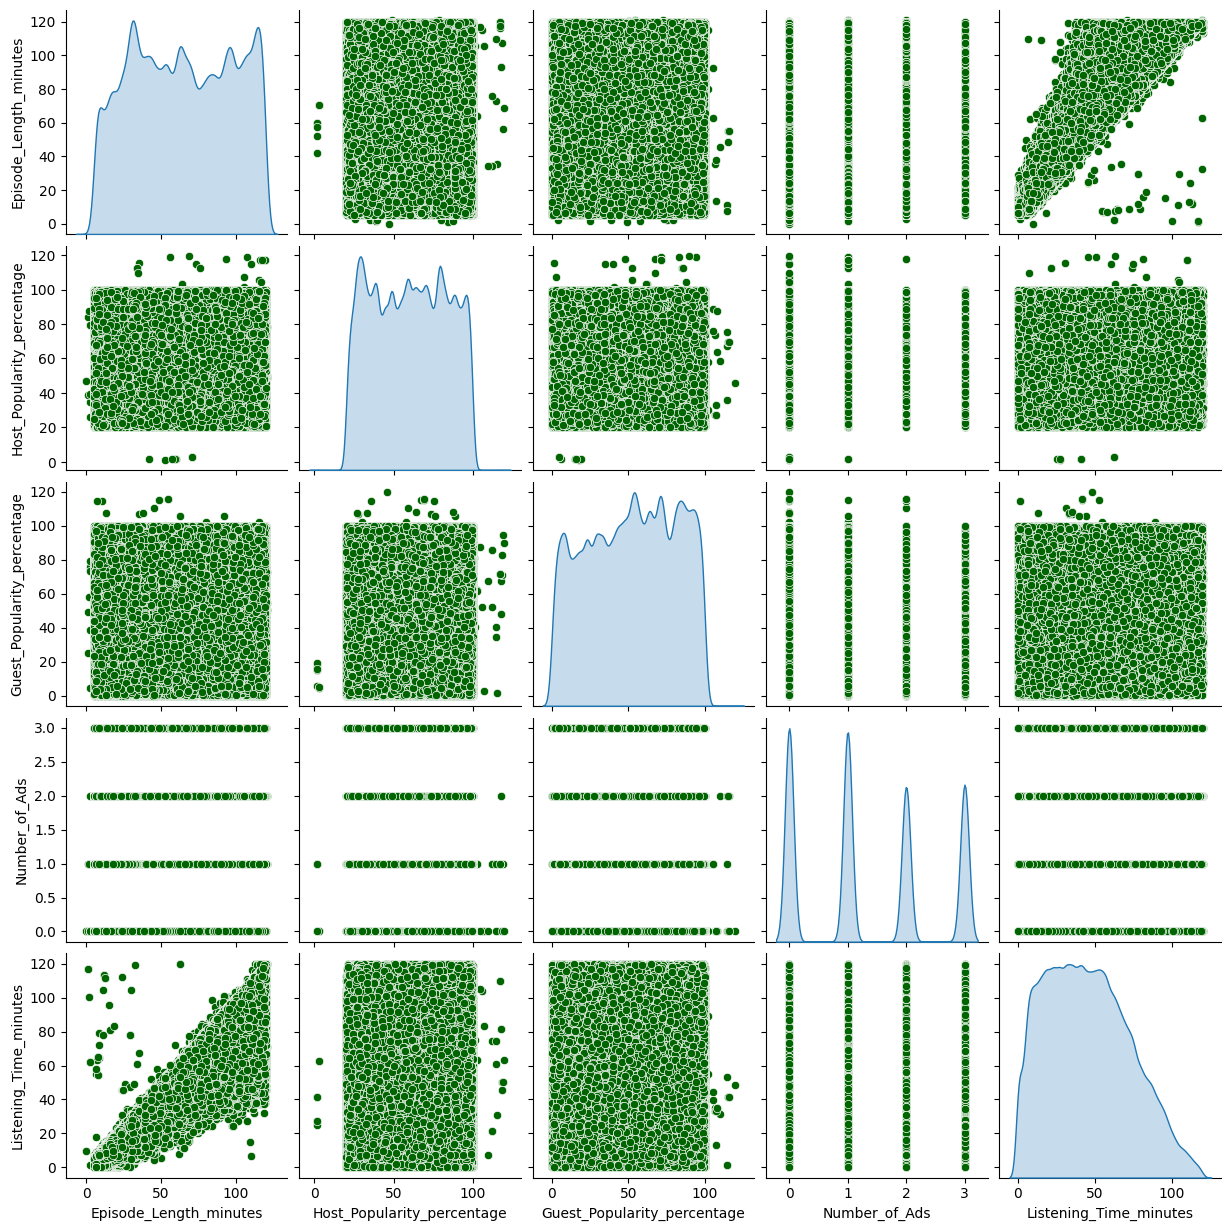

In [14]:
sns.pairplot(train[num_cols], diag_kind="kde", plot_kws={'color': 'darkgreen'})

### <span style="color: #048f29;">Correlation Matrix:</span>

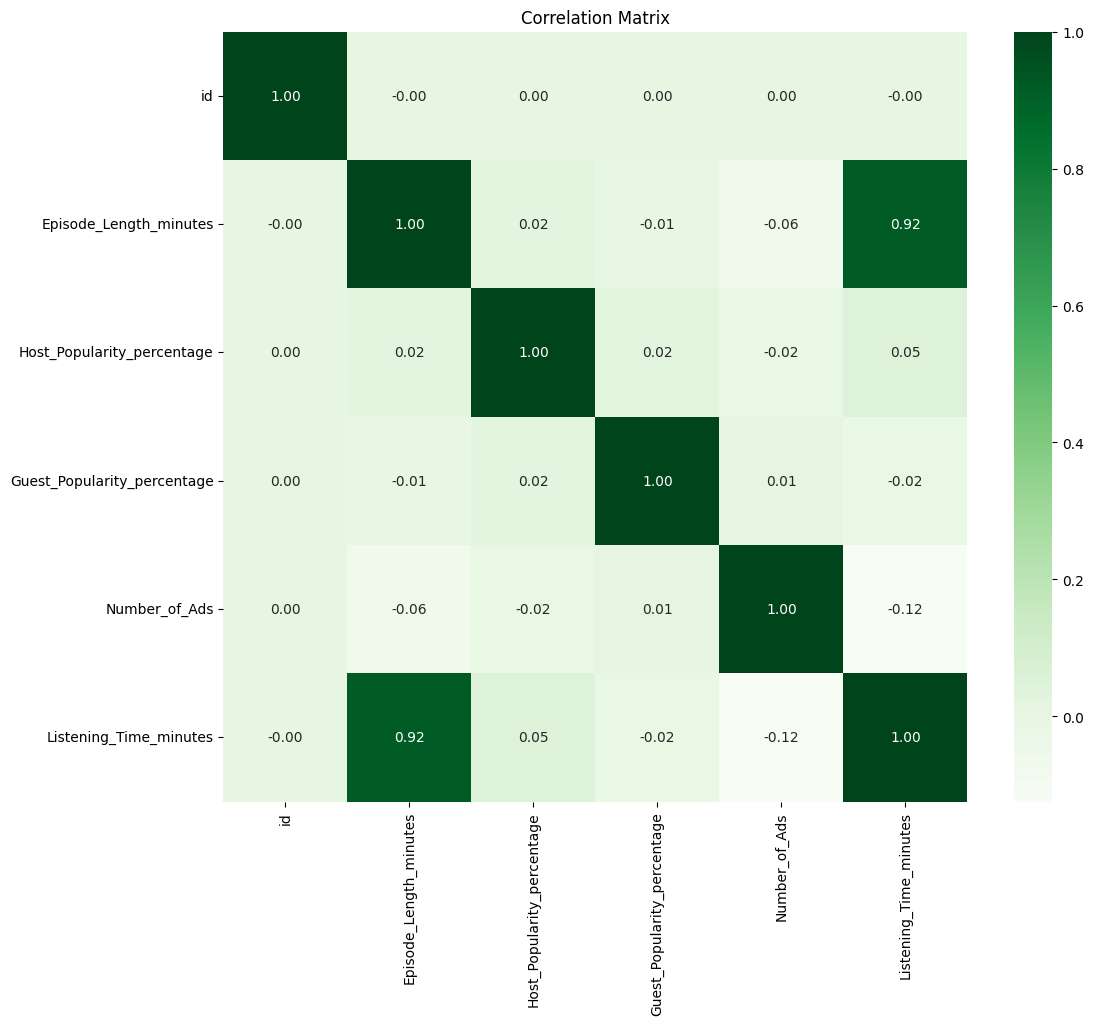

In [15]:
corr_matrix = train.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="Greens", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

<a id="1"></a>
# <p style="background-color:#02991d;font-family:georgia,serif;color:#FFF8ED;font-size:120%;text-align:center;border-radius:10px 10px;">Preprocessing & Feature Engineering</p>

---
* I will create a feature to measue the Ratio between Listening_Time_minutes and Episode_Length_minutes, due to the strong linear correlation between them.

In [16]:
def preprocess_data(df, is_train=True):
    df = df.copy()
    
    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)
    
    # Create some features
    df['Episode_Length_squared'] = df['Episode_Length_minutes'] ** 2
    df["ads_possibility"] = np.where(
    df["Number_of_Ads"] == 0, 
    0,  
    round(df["Episode_Length_minutes"] / df["Number_of_Ads"], 5)
)
    # Identify numeric columns 
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if is_train and 'Listening_Time_minutes' in numeric_cols:
        numeric_cols.remove('Listening_Time_minutes')
    
    # Fill missing numeric values with the median
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Identify categorical columns and fill missing values with "Unknown"
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        df[col].fillna("Unknown", inplace=True)
        
    return df

In [17]:
train = preprocess_data(train, is_train=True)
test = preprocess_data(test, is_train=False)

In [18]:
# local CV
def run_cv(model, X, y, folds=5):

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmse_scores = []
    
    # Use tqdm to display progress for CV folds
    for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=folds, desc="CV Folds"), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)
        print(f"Fold {fold} RMSE: {rmse:.4f}")
    
    print(f"\nMean RMSE: {np.mean(rmse_scores):.4f}")
    return rmse_scores

In [19]:
y = train['Listening_Time_minutes']
X = train.drop('Listening_Time_minutes', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [20]:
# pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
    ]
)

best_params = {'n_estimators': 947, 'max_depth': 10, 'learning_rate': 0.0748978774441599,
               'gamma': 1.2232257195658944, 'min_child_weight': 3, 'subsample': 0.8725507716641051,
               'colsample_bytree': 0.5017977778471705}
# XGBoost 
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(**best_params, random_state=42, objective='reg:squarederror'))
])

# Linear Regression 
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# LightGBM Pipeline 
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(n_estimators=100, random_state=42))
])

# For SVM, scaling 
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', SVR())
])

In [21]:
def objective(trial):
    # Define hyperparameters to search over
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    # Build the pipeline with the current trial's hyperparameters
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(**params, random_state=42, objective='reg:squarederror'))
    ])
    
    # Use a simple train/validation split for tuning
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [22]:
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)
#print("Best hyperparameters:", study.best_params)

In [23]:
#Mean RMSE: 13.3430
print("Linear Regression CV Results:")
#run_cv(lr_pipeline, X, y, folds=5)

Linear Regression CV Results:


In [24]:
#Mean RMSE: 12.7977
print("XGBoost CV Results:")
#run_cv(xgb_pipeline, X, y, folds=5)

XGBoost CV Results:


In [25]:
xgb_pipeline.fit(X, y)
test_predictions = xgb_pipeline.predict(test)
# Replace the target column with predictions
submission["Listening_Time_minutes"] = test_predictions

# Save the final submission file
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
